## Question 2.1 

In this task you will carry out a classification task for a subset of CIFAR-10/100 data using PyTorch. The data and images needed for the task are in the 2 1 folder. Follow the instructions below to complete this task. Complete your code in the provided Notebook file.

Submit this notebook file alongside the report and model checkpoint. In this task, we will beperforming transfer learning on the CIFAR-10/100 Dataset. You will be expected to load inexisting pre-trained models, adapt said models for the current task and optimise the models.

In [26]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
from torchinfo import summary
from tqdm import tqdm
import sys 
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import seaborn as sns


## Transform, loader, data, batch, and classes

In [2]:
# Define transformation of the datasets
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to the input size of VGG16
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

batch_size = 128

train_dataset = ImageFolder(root='CIFAR-10/train', transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = ImageFolder(root='CIFAR-10/test', transform=data_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plt_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Modified VGG16 net


## Model to train

In [41]:
class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedVGG16, self).__init__()
        # Load the pre-trained VGG16 model
        self.vgg16 = models.vgg16(weights='IMAGENET1K_V1')
        
        # Modify the last fully connected layer to output 10 classes
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x

modified_model_CIFAR_10 = ModifiedVGG16(num_classes=10)
print(modified_model_CIFAR_10)

ModifiedVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

# Criterion, optimizer

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modified_model_CIFAR_10.parameters(),lr=0.01,momentum=0.9)

In [49]:
writer = SummaryWriter('./2_1/runs"')

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(device)

# Function to train for one epoch
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    
    model.train()
    model.to(device)

    mean_loss = torch.zeros(1).to(device)
    optimizer.zero_grad()
    
    # Wrap data_loader with tqdm for progress bar
    data_loader = tqdm(data_loader, file=sys.stdout)

    for iter, data in enumerate(data_loader):

        inputs, labels = data

        inputs = data[0].to(device)
        labels = data[1].to(device)

        net_out = model(inputs)

        loss = criterion(net_out, labels)
        loss.backward()

        mean_loss = (mean_loss * iter + loss.detach()) / (iter + 1)
        data_loader.desc = f"[epoch{epoch}] mean_loss: {round(mean_loss.item(), 5)}"

        if not torch.isfinite(loss):
            print("ending training", loss)
            sys.exit(1)
            
        optimizer.step()
        optimizer.zero_grad()

        # torch.save(model.state_dict(), f"{arg.save_weights}/model-{epoch}.pth")

    return mean_loss.item()


mps


In [51]:
def plot_classes(model, images, labels):

    model.eval()
    with torch.no_grad():
        preds = model(images)
        preds_softmax = F.softmax(preds, dim=1)
        pred_probs, pred_labels = torch.max(preds_softmax, dim=1)
    
    fig = plt.figure(figsize=(12, 48))
    for idx in range(min(4, images.shape[0])):  # Show 4 images from batch
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        plt_imshow(images[idx], one_channel=False)
        ax.set_title(f"{classes[pred_labels[idx]]}, {pred_probs[idx]:.5f}\n(label: {classes[labels[idx]]})",
                     color=("green" if pred_labels[idx] == labels[idx] else "red"))
    
    writer.add_figure('predictions vs. actuals', fig, step)
    model.train()

# Traning the model

[epoch0] mean_loss: 1.86079: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]
Epoch 1/20, Train Loss: 1.86079
[epoch1] mean_loss: 1.25327: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]
Epoch 2/20, Train Loss: 1.25327
[epoch2] mean_loss: 0.9262: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s] 
Epoch 3/20, Train Loss: 0.92620
[epoch3] mean_loss: 0.5873: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s] 
Epoch 4/20, Train Loss: 0.58730
[epoch4] mean_loss: 0.44618: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]
Epoch 5/20, Train Loss: 0.44618
[epoch5] mean_loss: 0.3361: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s] 
Epoch 6/20, Train Loss: 0.33610
[epoch6] mean_loss: 0.20926: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]
Epoch 7/20, Train Loss: 0.20926
[epoch7] mean_loss: 0.15599: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]
Epoch 8/20, Train Loss: 0.15599
[epoch8] mean_loss: 0.12057: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]
Epoch 9/20, Train Loss: 0.12057
[epoch9] mean_loss:

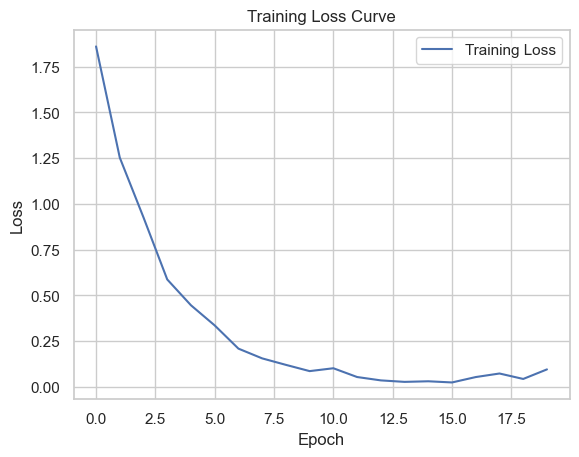

In [52]:
num_epochs = 20;

# Initialize lists to store loss and accuracy values
train_losses = []

for epoch in range(num_epochs):
    # Train one epoch and get the training loss
    train_loss = train_one_epoch(modified_model_CIFAR_10, optimizer, train_loader, device, epoch)
    
    # Append the training loss to the list
    train_losses.append(train_loss)
    
    # Print training progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5f}")
    
# Plotting the loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig('training_loss_curve.png')  # Save the loss curve plot

# Closing the tensorboard writer
writer.close()


# Save the model

In [54]:
if os.path.exists('./weights') is False:
    os.makedirs('./weights')

PATH = './weights2'

torch.save(modified_model_CIFAR_10.state_dict(), f'{PATH}/model{3}.pth')

# Load the Model

In [55]:
updated_model = './weights2/model3.pth'
modified_model_CIFAR_10.load_state_dict(torch.load(updated_model))
print(modified_model_CIFAR_10)

ModifiedVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

# Testing the Model

In [56]:
total_loss = 0.0
correct_predictions = 0
total_images = 0

for images, labels in test_loader:

    images, labels = images.to(device), labels.to(device)

    outputs = modified_model_0(images)
    
    loss = criterion(outputs, labels)
    
    total_loss += loss.item()
    
    _, predicted = torch.max(outputs.data, 1)
    
    total_images += labels.size(0)
    
    correct_predictions += (predicted == labels).sum().item()


average_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_images

print(f'Average Cross-Entropy Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Average Cross-Entropy Loss: 1.6874
Accuracy: 0.7100


# Show accuracy and entropy per class

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
total_loss = 0.0
correct_predictions = 0
total_images = 0
correct_predictions_per_class = {}
total_images_per_class = {}

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = modified_model_0(images)
    loss = loss_fn(outputs, labels)
    total_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_images += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

    # Update the per-class correct predictions and total images
    for i, label in enumerate(labels):
        label_str = str(label.item())
        if label_str not in correct_predictions_per_class:
            correct_predictions_per_class[label_str] = 0
            total_images_per_class[label_str] = 0
        if predicted[i] == labels[i]:
            correct_predictions_per_class[label_str] += 1
        total_images_per_class[label_str] += 1

average_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_images

for classname, correct_count in correct_predictions_per_class.items():
    total_images_for_class = total_images_per_class[classname]
    accuracy = 100 * float(correct_count) / total_images_for_class
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    pred_probs = torch.softmax(outputs, dim=1)
    avg_cross_entropy = -torch.log(pred_probs[range(len(labels)), labels]).mean().item()
    print(f'Average cross entropy for class: {classname:5s} is {avg_cross_entropy:.2f}')

Accuracy for class: 2     is 72.0 %
Average cross entropy for class: 2     is 1.67
Accuracy for class: 8     is 66.0 %
Average cross entropy for class: 8     is 1.67
Accuracy for class: 5     is 60.0 %
Average cross entropy for class: 5     is 1.67
Accuracy for class: 4     is 60.0 %
Average cross entropy for class: 4     is 1.67
Accuracy for class: 3     is 48.0 %
Average cross entropy for class: 3     is 1.67
Accuracy for class: 9     is 84.0 %
Average cross entropy for class: 9     is 1.67
Accuracy for class: 1     is 92.0 %
Average cross entropy for class: 1     is 1.67
Accuracy for class: 0     is 80.0 %
Average cross entropy for class: 0     is 1.67
Accuracy for class: 6     is 66.0 %
Average cross entropy for class: 6     is 1.67
Accuracy for class: 7     is 84.0 %
Average cross entropy for class: 7     is 1.67


## Load CIFAR-100

In [62]:
class ModifiedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)

    def __getitem__(self, index):
        original_image, original_label = super().__getitem__(index)
        if original_label == 0:
            # Change label 0 to 10
            original_label = 10
        return original_image, original_label

# Define transformation of the datasets
transform_2 = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to the input size of VGG16
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

batch_size = 128

# Create a modified dataset using ModifiedImageFolder
train_dataset_100 = ModifiedImageFolder(root='CIFAR-100/train', transform=transform_2)

train_loader_100 = torch.utils.data.DataLoader(train_dataset_100, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bycicle')

print(train_dataset_100[1])


(tensor([[[ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  0.9765,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
         [ 1.0000,  0.9765,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
         ...,
         [ 1.0000,  0.9294,  0.3333,  ..., -0.6078, -0.5529,  0.6392],
         [ 1.0000,  0.9686,  0.9765,  ..., -0.6863,  0.2706,  0.9686],
         [ 1.0000,  0.9765,  0.9765,  ...,  0.1373,  0.9451,  0.9922]],

        [[ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  0.9765,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
         [ 1.0000,  0.9765,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
         ...,
         [ 1.0000,  0.9294,  0.3176,  ..., -0.6078, -0.5529,  0.6392],
         [ 1.0000,  0.9686,  0.9686,  ..., -0.6863,  0.2706,  0.9686],
         [ 1.0000,  0.9765,  0.9765,  ...,  0.1373,  0.9451,  0.9922]],

        [[ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  0.9765,  0.9843,  ...,  

# Redefine the model from above in separate variable to avoid counter instantiation across models

In [57]:
# class ModifiedVGG16(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ModifiedVGG16, self).__init__()
#         # Load the pre-trained VGG16 model
#         self.vgg16 = models.vgg16(weights='IMAGENET1K_V1')
        
#         # Modify the last fully connected layer to output 10 classes
#         self.vgg16.classifier[6] = nn.Linear(4096, num_classes)

#     def forward(self, x):
#         x = self.vgg16(x)
#         return x

# CIFAR_100_model = ModifiedVGG16(num_classes=10)
# print(CIFAR_100_model)

# Modify the architecture s oit fits 11 classes

In [58]:
model_for_11 = './weights/model2.pth'
modified_model_CIFAR_10.load_state_dict(torch.load(model_for_11))

num_classes = 11;

# Change number of classes
pretrained_weights_cifar_10 = modified_model_CIFAR_10.vgg16.classifier[6].weight.data.clone()
pretrained_bias_cifar_10 = modified_model_CIFAR_10.vgg16.classifier[6].bias.data.clone()

modified_model_CIFAR_10.vgg16.classifier[6] = torch.nn.Linear(in_features=4096, out_features=11, bias=True)
modified_model_CIFAR_10.vgg16.classifier[6].weight.data = pretrained_weights_cifar_10
modified_model_CIFAR_10.vgg16.classifier[6].bias.data = pretrained_bias_cifar_10

model_100 = modified_model_CIFAR_10.vgg16
print(model_100)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:

class CustomCIFAR100(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root, transform)  # 
        self.labels = []  # 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # 获取父类中的数据和标签
        image, label = self.dataset[index]

        # 如果标签是0（假设0代表自行车类别），则将其改为10
        # 否则，保持标签不变
        if label == 0:
            label = 10
        self.labels.append(label)  # 将标签添加到列表中

        return image, label


train_set_100 = CustomCIFAR100('./CIFAR-100/train', transform_2)

train_loader_100 = torch.utils.data.DataLoader(train_set_100, batch_size=100, shuffle=True)
for iter, data in enumerate(train_loader_100):
    images = data[0]
    labels = data[1]
    print(images.shape)
    print(np.unique(labels))
    break

for iter, data in enumerate(train_loader_100):
    images = data[0]
    labels = data[1]
    print(images.shape)
    print(np.unique(labels))
    break
print(train_loader_100)

torch.Size([100, 3, 32, 32])
[10]
torch.Size([100, 3, 32, 32])
[10]


# Redefine optimizer

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modified_model_CIFAR_10.parameters(),lr=0.01,momentum=0.9)

# Training the 11 classes model

In [65]:
# Set Seaborn style
sns.set(style="whitegrid")

# Initialize an empty list to store training losses
train_losses = []

num_epochs = 20

writer = SummaryWriter('./2_1/runs"')

# Loop over epochs
for epoch in range(num_epochs):
    # Call train_one_epoch function for each epoch
    train_loss = train_one_epoch(modified_model_CIFAR_10, optimizer, train_loader_100, device, epoch)
    
    # Append the training loss to the list
    train_losses.append(train_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5f}")

# Plot the loss curve using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, marker='o', color='b', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(False)

# Save the plot
plt.savefig('loss_curve_seaborn.png')

# Display the plot
plt.show()


  0%|          | 0/2 [00:01<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'ModifiedImageFolder' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'ModifiedImageFolder' on <

RuntimeError: DataLoader worker (pid(s) 64628) exited unexpectedly

# Save the model

In [21]:
PATH='./weights'
torch.save(modified_model.state_dict(), f'{PATH}/2-1 11.pth')